In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
from tqdm import trange

from agents.dqn import DoubleDQNAgent, QNetwork
from environment.env import GridEnvDeform, POMDPWrapper_v0
import matplotlib.pyplot as plt
from utils.belief import update_belief, belief_entropy



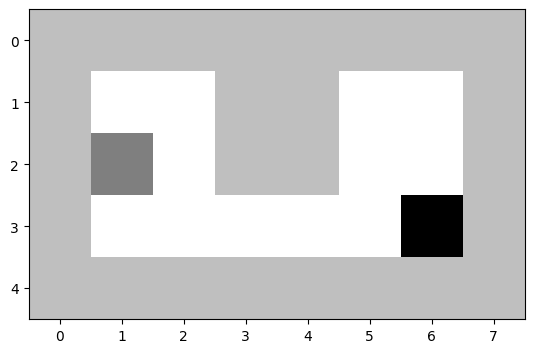

States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]



In [2]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")

T = torch.load(f"models/T_maze_{N}.pt", weights_only=True)
R = torch.load(f"models/R_maze_{N}.pt", weights_only=True)
O = torch.load(f"models/O_maze_{N}.pt", weights_only=True)


In [3]:
agent = DoubleDQNAgent(state_dim=144, action_dim=4, lr = 0.01)

pomdp_env = POMDPWrapper_v0(env, agent, T, R, O, state_dict, obs_dict, thetas)

# QMDP

In [4]:
# import the MDP solution model (tabular q in this case)
Q = np.load(f"agents/tabularQ_maze_{N}.npy")

Actual State:  ((2, 3, 0), (1, 1))
argmax and max Belief:  ((2, 1, 0), (1, 1)) tensor(0.2500)
Belief entropy:  2.0


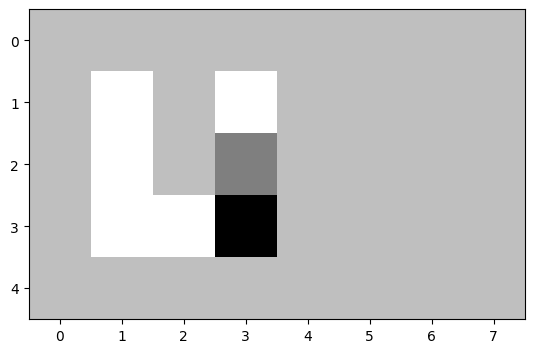

Chosen action:  2
Actual State:  ((3, 3, 2), (1, 1))
argmax and max Belief:  ((3, 3, 2), (1, 1)) tensor(1.)
Belief entropy:  -0.0


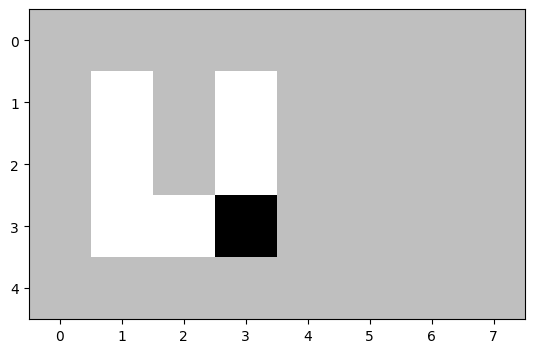

np.float64(1.0)

In [5]:
def eval_qmdp_tabular(env : GridEnvDeform, Q, num_episodes=100, max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()

        obs = env.get_observation()

        b_0 = torch.ones(len(states)) / len(states)   
        b = update_belief(b_0, 0, obs_dict[tuple(obs)],T,O)

        print("Actual State: ", s)
        print("argmax and max Belief: ", states[torch.argmax(b)], torch.max(b))
        print("Belief entropy: ", belief_entropy(b))


        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            if render:
                env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = np.argmax(Q[torch.argmax(b)])
            next_state, reward, done, _, info = env.step(action.item(), s, execute=render)
            
            s = next_state
            next_obs = env.get_observation(next_state)

            b_prime = update_belief(b, action, obs_dict[tuple(next_obs)],T,O)
            b = b_prime

            episode_reward += reward
            
            print("Chosen action: ", action)
            print("Actual State: ", next_state)
            print("argmax and max Belief: ", states[torch.argmax(b_prime)], torch.max(b_prime))
            print("Belief entropy: ", belief_entropy(b_prime))


            if done or c == 1:
                total_rewards.append(episode_reward)
                if done:
                    env.render()
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

eval_qmdp_tabular(env, Q, num_episodes=1,max_episode_steps=10, render=True)

In [16]:
s, _ = env.reset()

obs = env.get_observation()


In [17]:
b_0 = torch.ones(len(states)) / len(states)   
b = update_belief(b_0, 0, obs_dict[tuple(obs)],T,O)


In [33]:
orientation = 3
deformation = (1,1)

for orientation in range(4):
    belief = np.zeros(env.maze.shape) - np.inf
    for s, state in enumerate(states):
        if state[1] == deformation and state[0][2] == orientation:
            belief[state[0][0],state[0][1]] = b[s]


In [34]:
belief

array([[      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf,       -inf],
       [      -inf, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ,       -inf],
       [      -inf, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ,       -inf],
       [      -inf, 0.09999999, 0.        , 0.        , 0.        ,
        0.        , 0.        ,       -inf],
       [      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf,       -inf]])

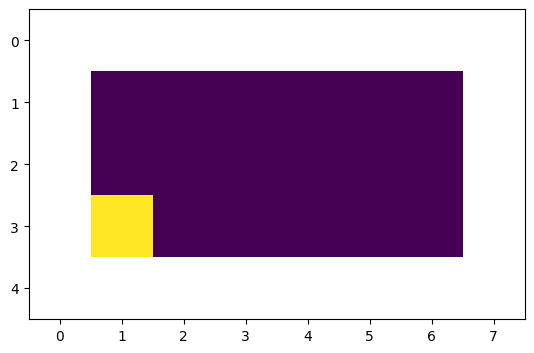

In [35]:
# show image of belief
plt.imshow(belief)

In [12]:
b

tensor([0.0606, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0606, 0.0000,
        0.0000, 0.0303, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0303,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0303, 0.0606, 0.0000, 0.0303, 0.0000,
        0.0000, 0.0000, 0.0303, 0.0000, 0.0606, 0.0000, 0.0606, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0303, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0303,
        0.0000, 0.0303, 0.0000, 0.0303, 0.0000, 0.0303, 0.0000, 0.0303, 0.0000,
        0.0606, 0.0000, 0.0303, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

# Thompson Sampling

Actual State:  ((2, 1, 2), (2, 1))
argmax and max Belief:  ((1, 2, 3), (2, 1)) tensor(0.2000)
Belief entropy:  2.321928024291992


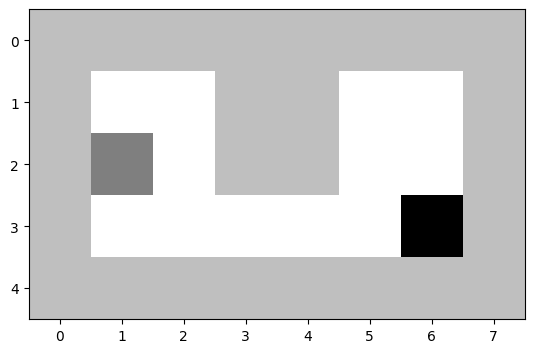

Chosen action:  3
Actual State:  ((2, 2, 1), (2, 1))
argmax and max Belief:  ((2, 2, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0


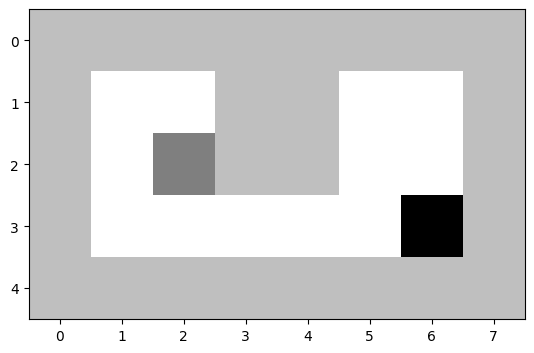

Chosen action:  1
Actual State:  ((3, 2, 2), (2, 1))
argmax and max Belief:  ((3, 2, 2), (2, 1)) tensor(1.)
Belief entropy:  -0.0


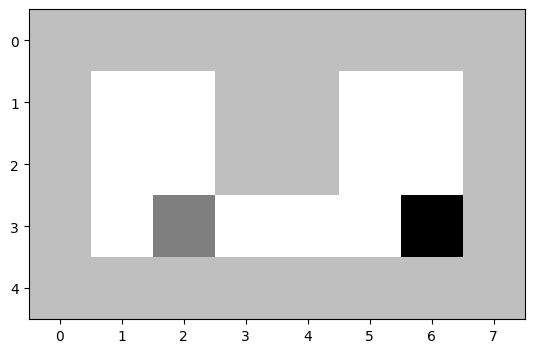

Chosen action:  3
Actual State:  ((3, 3, 1), (2, 1))
argmax and max Belief:  ((3, 3, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0


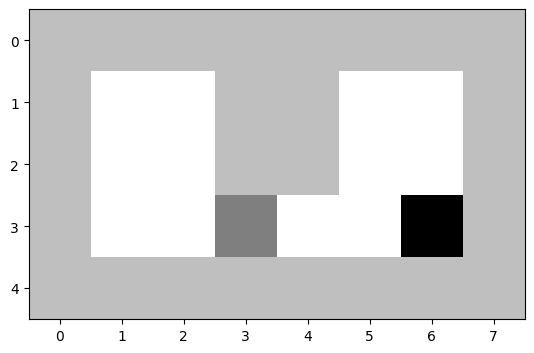

Chosen action:  0
Actual State:  ((3, 4, 1), (2, 1))
argmax and max Belief:  ((3, 4, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0


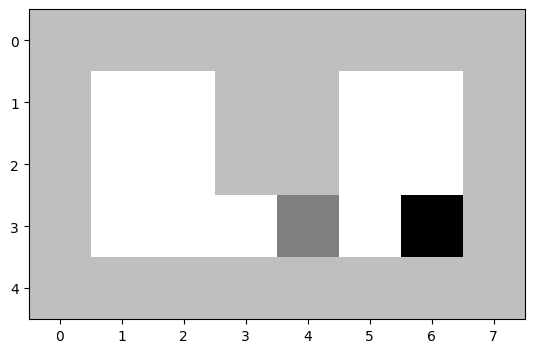

Chosen action:  0
Actual State:  ((3, 5, 1), (2, 1))
argmax and max Belief:  ((3, 5, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0


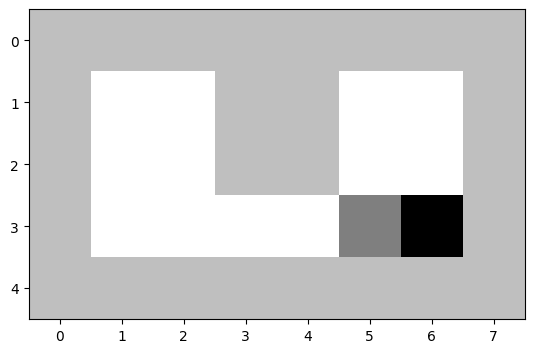

Chosen action:  0
Actual State:  ((3, 6, 1), (2, 1))
argmax and max Belief:  ((3, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0


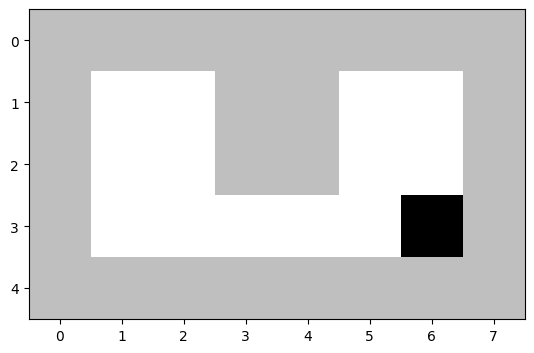

np.float64(-1.5)

In [70]:
def eval_thompson_tabular(env : GridEnvDeform, Q, num_episodes=100, max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()

        obs = env.get_observation()

        b_0 = torch.ones(len(states)) / len(states)   
        b = update_belief(b_0, 0, obs_dict[tuple(obs)],T,O)

        print("Actual State: ", s)
        print("argmax and max Belief: ", states[torch.argmax(b)], torch.max(b))
        print("Belief entropy: ", belief_entropy(b))


        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            if render:
                env.render()

            # Agent takes an action using a greedy policy (without exploration)
            sampled_s = torch.multinomial(b, 1).item()
            action = np.argmax(Q[sampled_s])
            next_state, reward, done, _, info = env.step(action.item(), s, execute=render)
            
            s = next_state
            next_obs = env.get_observation(next_state)

            b_prime = update_belief(b, action, obs_dict[tuple(next_obs)],T,O)
            b = b_prime

            episode_reward += reward
            
            print("Chosen action: ", action)
            print("Actual State: ", next_state)
            print("argmax and max Belief: ", states[torch.argmax(b_prime)], torch.max(b_prime))
            print("Belief entropy: ", belief_entropy(b_prime))


            if done or c == 1:
                total_rewards.append(episode_reward)
                if done:
                    env.render()
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

eval_thompson_tabular(env, Q, num_episodes=1,max_episode_steps=10, render=True)

# DQN on Belif Space


In [5]:
num_episodes = 1000
max_episode_steps = 100

rewards = []
evalrewards = []

for episode in trange(num_episodes):
    
    obs, info = pomdp_env.reset()
    s = info['actual_state']

    b_0 = torch.ones(len(states)) / len(states)   
    b = update_belief(b_0, 0, obs, T,O)
    
    episode_reward = 0
    done = False
    
    steps = 0
    while not done and steps < max_episode_steps:
        
        for action in range(4):
            next_obs, reward, done, info = pomdp_env.step(s,action)
            b_prime = update_belief(b, action,obs,T,O)
            agent.store_transition(b, action, reward, b_prime, done)

        action = agent.choose_action(b)
        obs, reward, done, info = pomdp_env.step(s,action)
        next_state = info['actual_state']
        b_prime = update_belief(b, action,obs,T,O)


        agent.train()
        b = b_prime
        s = next_state

        episode_reward += reward
        steps += 1        
    
    agent.update_epsilon()
    rewards.append(episode_reward)
            


print("Training complete.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▎         | 37/1000 [00:08<03:53,  4.12it/s]


KeyboardInterrupt: 

In [ ]:
num_episodes = 1000
max_episode_steps = 100

rewards = []
evalrewards = []

for episode in trange(num_episodes):
    
    obs, info = pomdp_env.reset()
    s = info['actual_state']

    b_0 = torch.ones(len(states)) / len(states)   
    b = update_belief(b_0, 0, obs, T,O)
    
    episode_reward = 0
    done = False
    
    steps = 0
    while not done and steps < max_episode_steps:
        
        for action in range(4):
            next_obs, reward, done, info = pomdp_env.step(s,action)
            b_prime = update_belief(b, action,obs,T,O)
            agent.store_transition(b, action, reward, b_prime, done)

        action = agent.choose_action(b)
        obs, reward, done, info = pomdp_env.step(s,action)
        next_state = info['actual_state']
        b_prime = update_belief(b, action,obs,T,O)


        agent.train()
        b = b_prime
        s = next_state

        episode_reward += reward
        steps += 1        
    
    agent.update_epsilon()
    rewards.append(episode_reward)
            


print("Training complete.")
